Assign the *Pets* dataset to a path object

In [1]:
from fastai.vision.all import *
from fastbook import *
path = untar_data(URLs.PETS)

In [2]:
path

Path('/home/petewin/.fastai/data/oxford-iiit-pet')

Change the base path of the `Path` object to a local relative one, in this case '.'

This will make our Path objects reference the hidden `.fastai/data` folder as if it were our local working directory

In [3]:
Path.BASE_PATH = path

In [4]:
Path.BASE_PATH

Path('.')

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

We'll be focusing on classification rather than localization, and so we'll ignore the annotations 

Most functions in fastai are going to return the `L` class, which is like an enhancement to the standard python `list` class

It can do a few extra things:

In [6]:
fname = (path/"images").ls()[:3]
fname

(#3) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg')]

Above, it's showing that each item is a `Path` object and that there are `#3` items in this particular list

For longer lists it will add an ellipse `...` rather than try to spit out however many items

In [7]:
fname = (path/"images").ls()
fname

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

We need to take note of the filenames here because some are one word, some are multiple words, all using an underscore `_` as a delimiter

In [8]:
fname = (path/"images").ls()[0]
fname

Path('images/Birman_115.jpg')

Regex to find any amount of characters until the last underscore is reached, then looks for a digit string and `.jpg`

In [9]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Birman']

Fastai comes with a built-in `RegexLabeller` class, which we can use in creating out `pets` DataBlock

In [10]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

I'm always curious about some of the 'black box' aspects of programming in general. Not that it's really a black box, but I've made plenty of `DataBlock` objects at this point. So let's take a look under the hood

I'm going to make this a dataframe, just so it give me everything.<br>
`dir` is going to return all the attributes of my `pets` Datablock object now that it's created

In [11]:
df = pd.DataFrame(dir(pets))
df

,0
0,__class__
1,__delattr__
2,__dict__
3,__dir__
4,__doc__
5,__eq__
6,__format__
7,__ge__
8,__getattribute__
9,__gt__


In [12]:
pets.get_y

functools.partial(<function _using_attr at 0x7efb33b503a0>, <fastai.data.transforms.RegexLabeller object at 0x7efb26e51c00>, 'name')

There we go, I was looking for the values at `get_y`, specifically what `name` was doing, and turns out it's just hanging out in there as a string - so likely for labeling(duh, but I wanted to see how)

`item_tmfs` and `batch_tmfs` in the above `DataBlock` are a data augmentation strategy called *presizing*, which is meant to perform image augmentation while minimizing data destruction and maintaining good performance

#### Presizing

Needs:
- Images to be the same dimensions so they can collate to tensors to head to the GPU
- Minimize the number of distinct augmentation computations we perform

Therefore:
- Where possible compose augmentation transforms into fewer tranforms and uniform image sizes


Complications:
- If we perform augmentations after resizing, we may introduce empty zones, degrade data, or both

Therefore:
- *Presizing*
    - Resize images to larger dimensions(scale up)
    - Compose all common augmentation operations(including rescale down) into a single one, and perform only at the end of processing

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="../images/att_00060.png">

Above:
1. Crop full width or height:
    - This is an `item_tfms` so it's done each image before it's copied to GPU; makes sure all images are the same size
        - For training - Random Area
        - For validation - Always Center Crop at Object Origin

2. Random crop and augment:
    - This is a `batch_tfms`, so it's applied to a batch all at once on the GPU; so it's fast
        - For training - Random crop and other augmentations are done first
        - For validation - Only resize to the final size needed for the model is done here



In [13]:
# default pandas dataframe maxes
pd_row_default = pd.options.display.max_rows
pd_column_default = pd.options.display.max_columns

In [14]:
# # Original
# #hide_input
# #id interpolations
# #caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
# dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
#                    get_y=parent_label,
#                    item_tfms=Resize(460))
# # Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
# dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
# dls1.train.get_idxs = lambda: Inf.ones
# x,y = dls1.valid.one_batch()
# _,axs = subplots(1, 2)

# x1 = TensorImage(x.clone())
# x1 = x1.affine_coord(sz=224)
# x1 = x1.rotate(draw=30, p=1.)
# x1 = x1.zoom(draw=1.2, p=1.)
# x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
#                        Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
# x = Pipeline(tfms)(x)
# #x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
# TensorImage(x[0]).show(ctx=axs[0])
# TensorImage(x1[0]).show(ctx=axs[1]);

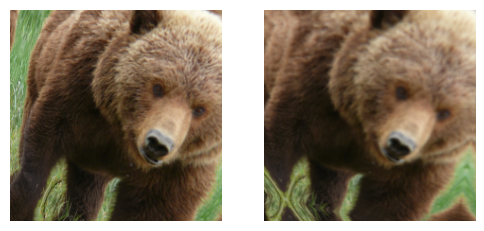

In [15]:
# Initialize a DataBlock with ImageBlock and CategoryBlock as blocks, using parent_label as get_y method, and resizing the image to 460
dlblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_y=parent_label,
                    item_tfms=Resize(460))

# Create a path object 'Up_directory' with '..' as the path
Up_directory = Path('..')

# Create dataloaders 'dls1' from the DataBlock 'dlblock1' with 100 instances of grizzly.jpg and batch size of 8
dls1 = dlblock1.dataloaders([(Up_directory/'images'/'grizzly.jpg')]*100, bs=8)

# Set get_idxs of train dataloader to return Inf.ones
dls1.train.get_idxs = lambda: Inf.ones

# Get one batch of validation data from dls1
x,y = dls1.valid.one_batch()

# Plot images using subplots
_,axs = subplots(1,2)

# Initialize x1 with x and convert it to TensorImage
x1 = TensorImage(x.clone())

# Apply affine_coord transformation to x1 with size of 224
x1 = x1.affine_coord(sz=224)

# Apply rotate transformation to x1 with draw angle of 30 and probability of 1
x1 = x1.rotate(draw=30, p=1.)

# Apply zoom transformation to x1 with draw factor of 1.2 and probability of 1
x1 = x1.zoom(draw=1.2, p=1.)

# Apply warp transformation to x1 with draw factors for x and y of -0.2 and 0.2 respectively and probability of 1
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Set up augmentations using Rotate, Zoom, and Warp
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])

# Apply the augmentations to x using Pipeline
x = Pipeline(tfms)(x)

# Show the first element of x after augmentations on first plot
TensorImage(x[0]).show(ctx=axs[0])

# Show the first element of x1 after augmentations on second plot
TensorImage(x1[0]).show(ctx=axs[1]);


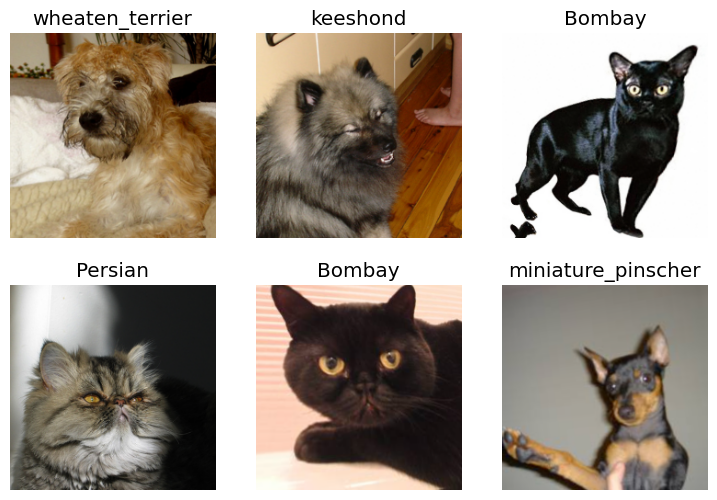

In [16]:
dls.show_batch(nrows=2, ncols=3)

To debug `DataBlock`s, we can use the `summary` method, which will attempt to make a batch from the source you give it, with lots of details

Below is a summary that forgets `Resize` transform for debugging:

Below is commented out because it distrupts `run all` - output is in markdown below it

In [17]:
# pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                             get_items=get_image_files,
#                             splitter=RandomSplitter(seed=42),
#                             get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")                         

```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

#### Train a Baseline

Most wait too long to train a baseline - do it early

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.561683,0.298076,0.089310,00:19
1,0.386878,0.252647,0.074425,00:18


Fastai will generally try to pick a loss function on it's own to fit the data and model you're using.

Since this is Image data and a categorical outcome it's going to default to *cross-entropy loss*

### Cross Entropy Loss

Benefits of cross-entropy loss:
- It works even when our dependant variable has more than 2 categories
- It results in faster and more reliable training 

To understand why it works for dependant variables with more than 2 categories, we have to understand what the data and activations seen by the loss function look like

### Viewing Activations and Labels

Activations
- To get a real batch of data from `DataLoaders`, we can use the `one_batch` method

In [19]:
x,y = dls.one_batch()

This returns the independant variable and the dependant variable as a mini-batch

In [20]:
x.shape

torch.Size([64, 3, 224, 224])

In [21]:
y

TensorCategory([ 6, 14, 27, 20, 12, 30, 19,  7, 17,  5,  2, 17, 22,  5, 31, 34, 35, 12, 25, 30,  6,  2, 13, 24, 23, 23, 17, 24, 22,  0, 22, 24, 18, 16, 30, 35, 17, 22, 28, 36, 25, 19, 12, 28, 31,  0,
                 7,  0, 17, 28,  1, 18, 17, 12,  9,  9, 31, 13, 23,  0,  2,  4, 35,  5], device='cuda:0')

- Batch size is 64 so we have 64 rows in this tensor
- Each is an interger between 0 and 36 (for 37 pet breeds)
- Using `Learner.get_preds` we can view the predictions(activation of the final layer of neural network)
- `Learner.get_preds` takes argument at 0 or 1, for train or valid, OR an iterator of batches
- So we can pass it a list with our batch to get our predictions
- Returns predictions and targets by default, but since we have targets, we can ignore them and assign to "`_`"

In [22]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([3.0025e-04, 5.0607e-05, 4.0462e-05, 1.0467e-05, 3.1698e-04, 1.5573e-04, 9.9303e-01, 3.7758e-03, 1.4656e-03, 2.1532e-05, 2.4000e-06, 1.0311e-05, 1.2121e-06, 2.6946e-05, 5.0401e-06,
            8.1728e-06, 2.1493e-07, 4.7131e-06, 7.5985e-06, 7.2672e-05, 4.0012e-05, 2.4422e-05, 3.4445e-05, 2.8207e-05, 1.3581e-04, 1.0855e-05, 1.0831e-05, 6.7630e-06, 3.1751e-05, 2.5743e-06,
            1.8796e-06, 2.1565e-04, 9.7478e-05, 2.5145e-05, 4.1153e-06, 6.5912e-06, 2.1100e-05])

Actual preds are 37 probabilites between 0 and 1 that add up to 1 total

In [23]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.0000))

To transform them into this 0 - 1 spread/sum we used a softmax activation

### Softmax

In the classification model, we used the softmax classification in the final layer to ensure the activations are between 0 and 1 and sum to 1

If softmax sounds familiar, it's because it looks like our sigmoid function

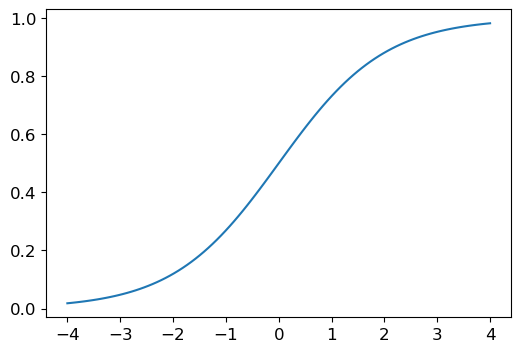

In [24]:
plot_function(torch.sigmoid, min=-4, max=4)

If we have more categories in our target(like 37), that means we'll need to apply this to more than a single column

We need an activation per category

Example
- Find for '3's and '7's
- Assume 6 images with 2 possible categories
- Create random numbers with std deviation of 2
- First column is 3's seond column is 7's

In [25]:
torch.random.manual_seed(42);

In [26]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't get sigmoid directly because the rows won't add up to 1

In [27]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [28]:
acts[:,0], acts[:,1], (acts[:,0] - acts[:,1]).sigmoid()

(tensor([ 0.6734,  0.4689, -2.2457,  4.4164,  0.9233,  1.0698]),
 tensor([ 0.2576,  0.4607, -0.3727, -1.2760,  0.5347,  1.6187]),
 tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661]))

In [29]:
1-(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.3975, 0.4979, 0.8668, 0.0034, 0.4041, 0.6339])

Softmax Function:
```python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [30]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

- For '3's and '7's example assume these are our labels

In [31]:
targ = tensor([0,1,0,1,1,0])

- And these are the softmax activation

In [32]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

- For each item of `targ` we select appropriate column of `sm_acts` tensor

In [33]:
idx = range(6)
sm_acts[idx, targ]


tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

Putting all columns in a table

In [34]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3", "7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
# html = t._repr_html_().split(' ')[1]
# html = re.sub(r'', r'', html)
# display(HTML(html))
t

/tmp/ipykernel_18835/591767774.py:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  t = df.style.hide_index()


3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [35]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

*Negative Log Likelihood*

In [36]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

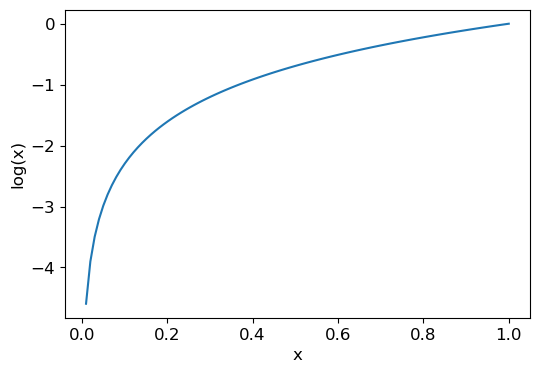

In [37]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

### Key Point - Log Relationship:

```
log(a*b) = log(a)+log(b)
```

Log increases linearly, even when underlying signal increase multiplicitavely or exponentially

We want our loss function to return a small value when the prediction is "good"(closer to 1), and large value when the prediction is bad(closer to 0)

So we flip it by taking the negative of the log

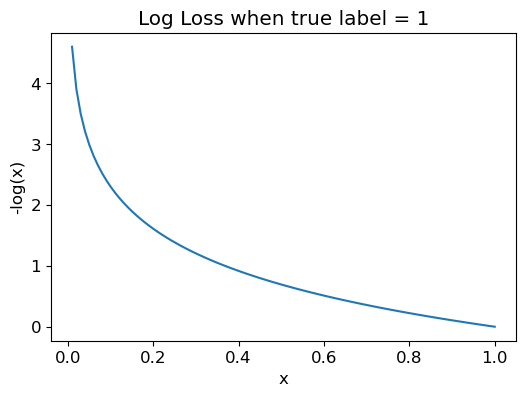

In [38]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='-log(x)', title="Log Loss when true label = 1" )

In [39]:
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
t

/tmp/ipykernel_18835/3562621766.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  t = df.style.hide_index()


3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


#### Negative Log Likelihood

In [40]:
loss_func = nn.CrossEntropyLoss()

In [41]:
loss_func(acts, targ)

tensor(1.8045)

In [42]:
F.cross_entropy(acts, targ)

tensor(1.8045)

By default PyTorch's loss functions will take the mean of the loss of all items, we can use `reduction='none'` to disable that

In [43]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

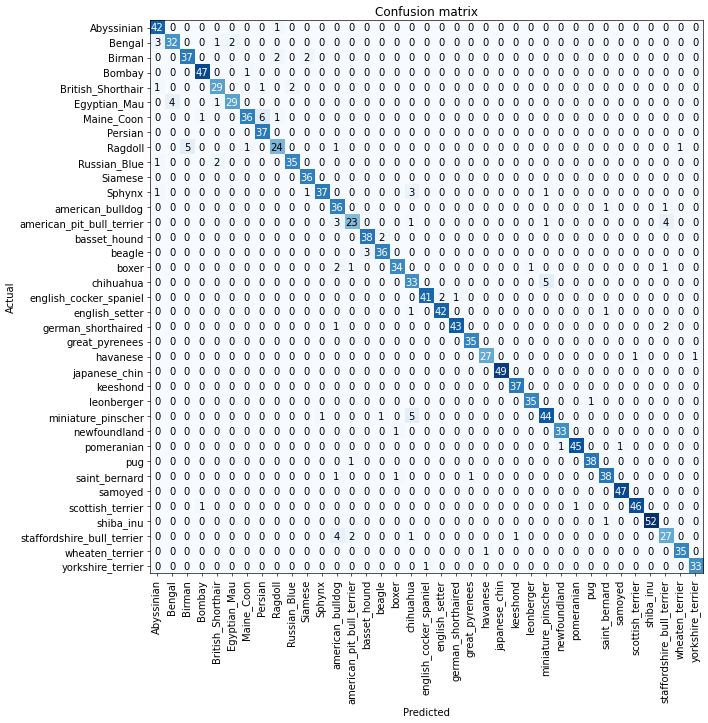

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [45]:
interp.most_confused(min_val=5)

[('Maine_Coon', 'Persian', 6),
 ('Ragdoll', 'Birman', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('miniature_pinscher', 'chihuahua', 5)]

Too high learning rate below

In [46]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,4.040434,3.215584,0.837618,00:19


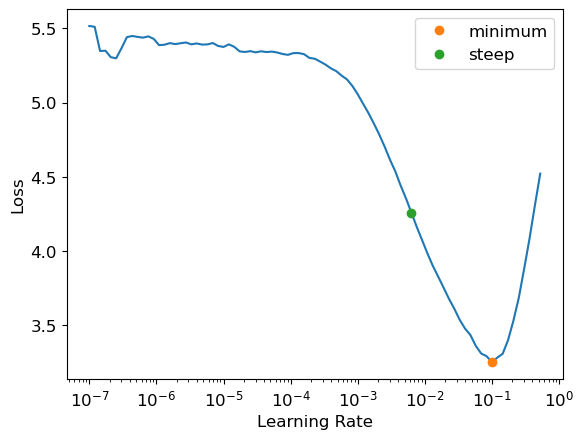

In [47]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [48]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-03


In [50]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.572863,0.299999,0.091340,00:19
1,0.370671,0.253363,0.077131,00:19


In [51]:
learn.fine_tune

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/mambaforge/lib/python3.10/site-packages/fastai/callback/schedule.py
Type:      method

In [53]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.269629,0.327970,0.104195,00:16
1,0.600040,0.264265,0.081867,00:16
2,0.383447,0.240234,0.072395,00:16


In [54]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

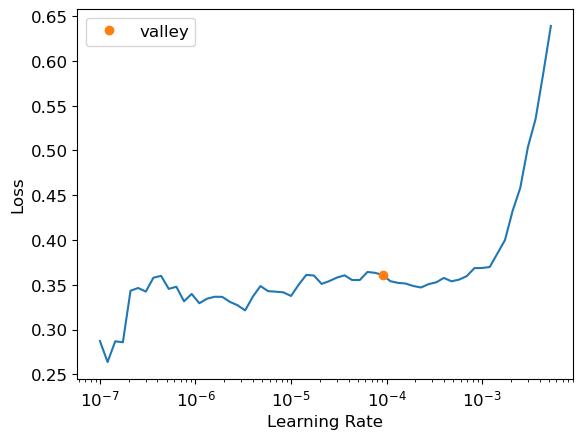

In [55]:
learn.lr_find()

In [56]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.326105,0.234080,0.071719,00:19
1,0.311947,0.223442,0.069689,00:18
2,0.270071,0.222548,0.070365,00:19
3,0.265491,0.215343,0.066982,00:19
4,0.265402,0.213988,0.065629,00:19
5,0.247349,0.215697,0.066306,00:19


### Descriminative Learning Rates